In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import random
#import cv2
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Changing directory to images
os.chdir("/content/drive/MyDrive/")

In [5]:
# Check Classes 
image_names=list(os.listdir("Database/"))
image_names.sort()
print(image_names)
class_number = len(image_names)

['COVID19', 'NORMAL', 'Viral_Pneumonia']


In [6]:
device = tf.test.gpu_device_name()
device

'/device:GPU:0'

In [7]:
# MODEL 

data_dir = "Database/"
batch_size = 128
img_height, img_width = 224,224
epochs = 50

In [54]:
# MODEL TRAINING


datagen= ImageDataGenerator(rescale=1/255,validation_split=.3,rotation_range=20,
                           shear_range=.2,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2)

# Flow training images in batches of batch_size using train_data 
train_generator= datagen.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= image_names,
                shuffle=False,
                seed=30)


datagen2=ImageDataGenerator(rescale=1/255,validation_split=.3)

val_generator=datagen2.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                classes= image_names,
                class_mode="categorical", 
                subset="validation", 
                shuffle=False, 
                seed=30)

## For evaluation
eval_train_generator= datagen.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= image_names,
                shuffle=False, 
                seed=30)

eval_val_generator=datagen2.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                classes= image_names,
                class_mode="categorical", 
                subset="validation", 
                shuffle=False, 
                seed=30)

Found 2919 images belonging to 3 classes.
Found 1250 images belonging to 3 classes.
Found 2919 images belonging to 3 classes.
Found 1250 images belonging to 3 classes.


In [60]:
VGG16_classifier=VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in VGG16_classifier.layers:
    layer.trainable=False

with tf.device(device):
  VGG16_model = tf.keras.Sequential([
                                     VGG16_classifier,
                                     MaxPooling2D(),
                                     Dense(img_height, activation='relu'),
                                     Flatten(),
                                     Dense(class_number, activation='softmax')
                                     ])
  
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


  VGG16_model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  VGG16_model_history = VGG16_model.fit(
      train_generator,
      validation_data=val_generator,
      epochs=epochs,
      verbose=1,       
      callbacks=[callback])

Epoch 1/50
23/23 [==============================] - 88s 4s/step - loss: 1.7481 - accuracy: 0.3662 - val_loss: 0.9076 - val_accuracy: 0.6144
Epoch 2/50
23/23 [==============================] - 83s 4s/step - loss: 1.0062 - accuracy: 0.4719 - val_loss: 0.6078 - val_accuracy: 0.7576
Epoch 3/50
23/23 [==============================] - 83s 4s/step - loss: 0.7377 - accuracy: 0.6292 - val_loss: 0.4260 - val_accuracy: 0.8528
Epoch 4/50
23/23 [==============================] - 83s 4s/step - loss: 0.6234 - accuracy: 0.7220 - val_loss: 0.3734 - val_accuracy: 0.8824
Epoch 5/50
23/23 [==============================] - 83s 4s/step - loss: 0.5502 - accuracy: 0.7710 - val_loss: 0.3371 - val_accuracy: 0.8840
Epoch 6/50
23/23 [==============================] - 83s 4s/step - loss: 0.3715 - accuracy: 0.8652 - val_loss: 0.4760 - val_accuracy: 0.8104
Epoch 7/50
23/23 [==============================] - 83s 4s/step - loss: 0.3266 - accuracy: 0.8982 - val_loss: 0.4305 - val_accuracy: 0.7944
Epoch 8/50
23/23 [==

In [61]:
# Train loss/ Train Accuracy
train_loss, train_acc = VGG16_model.evaluate(train_generator)
print("\n Train Accuracy:", train_acc)
print("\n Train Loss:", train_loss)

23/23 [==============================] - 64s 3s/step - loss: 0.2025 - accuracy: 0.9356

 Train Accuracy: 0.935594379901886

 Train Loss: 0.20248658955097198


In [62]:
# Test Loss/ Test Accuracy
test_loss, test_acc= VGG16_model.evaluate(val_generator)
print("\n Test Accuracy:", test_acc)
print("\n Test Loss:", test_loss)

10/10 [==============================] - 18s 2s/step - loss: 0.3187 - accuracy: 0.8736

 Test Accuracy: 0.8736000061035156

 Test Loss: 0.31866881251335144


INFO:tensorflow:Assets written to: VGG16_model/assets


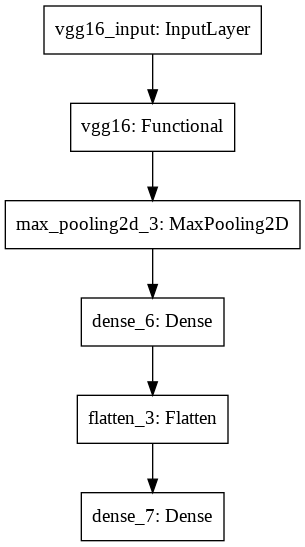

In [63]:
# Save Model 
VGG16_model.save('VGG16_model')
VGG16_model.save('VGG16_model/VGG16_model.h5')

VGG16_model_history_df = pd.DataFrame(VGG16_model_history.history) 
VGG16_model_history_df.to_csv('VGG16_model/history.csv')

tf.keras.utils.plot_model(
    VGG16_model, to_file='VGG16_model/architecture.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
# # Load in Model
# model_name = 'VGG16_model'
# new_model = tf.keras.models.load_model(model_name)

In [180]:
# Print Confusion Matrix for Analysis- Validation

Y_pred = VGG16_model.predict(val_generator, 1250 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('VGG16 Confusion Matrix- Validation')
conf_matrix = pd.DataFrame(
    confusion_matrix(val_generator.classes, y_pred), 
    index=['true: COVID19', 'true: NORMAL','true: Viral_Pneumonia'], 
    columns=['pred: COVID19', 'pred: NORMAL','pred: Viral_Pneumonia']
)
conf_matrix.to_csv("VGG16_model/confusion_matrix.jpeg")
print(conf_matrix)
print('\n')
print('Classification Report')
target_names = list(val_generator.class_indices.keys())
print(classification_report(val_generator.classes, y_pred, target_names=target_names))



VGG16 Confusion Matrix- Validation
                       pred: COVID19  pred: NORMAL  pred: Viral_Pneumonia
true: COVID19                    368             6                     24
true: NORMAL                       0           388                     16
true: Viral_Pneumonia              0           112                    336


Classification Report
                 precision    recall  f1-score   support

        COVID19       1.00      0.92      0.96       398
         NORMAL       0.77      0.96      0.85       404
Viral_Pneumonia       0.89      0.75      0.82       448

       accuracy                           0.87      1250
      macro avg       0.89      0.88      0.88      1250
   weighted avg       0.89      0.87      0.87      1250



In [181]:
# Print Confusion Matrix for Analysis- TRAINING

Y_pred = VGG16_model.predict(train_generator, 2919 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('VGG16 Confusion Matrix for Training')
conf_matrix = pd.DataFrame(
    confusion_matrix(train_generator.classes, y_pred), 
    index=['true: COVID19', 'true: NORMAL','true: Viral_Pneumonia'], 
    columns=['pred: COVID19', 'pred: NORMAL','pred: Viral_Pneumonia']
)
conf_matrix.to_csv("VGG16_model/confusion_matrix_train.jpeg")
print(conf_matrix)
print('\n')
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))


VGG16 Confusion Matrix for Training
                       pred: COVID19  pred: NORMAL  pred: Viral_Pneumonia
true: COVID19                    883             2                     44
true: NORMAL                       1           908                     35
true: Viral_Pneumonia             25            69                    952


Classification Report
                 precision    recall  f1-score   support

        COVID19       0.97      0.95      0.96       929
         NORMAL       0.93      0.96      0.94       944
Viral_Pneumonia       0.92      0.91      0.92      1046

       accuracy                           0.94      2919
      macro avg       0.94      0.94      0.94      2919
   weighted avg       0.94      0.94      0.94      2919



In [78]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
batch_size = 128
num_of_test_samples = 1250
predictions = VGG16_model.predict_generator(val_generator,  num_of_test_samples // batch_size+1)

y_pred = np.argmax(predictions, axis=1)

true_classes = val_generator.classes

class_labels = list(val_generator.class_indices.keys())   

print(class_labels)

print(confusion_matrix(val_generator.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


['COVID19', 'NORMAL', 'Viral_Pneumonia']
[[368   6  24]
 [  0 388  16]
 [  0 112 336]]
                 precision    recall  f1-score   support

        COVID19       1.00      0.92      0.96       398
         NORMAL       0.77      0.96      0.85       404
Viral_Pneumonia       0.89      0.75      0.82       448

       accuracy                           0.87      1250
      macro avg       0.89      0.88      0.88      1250
   weighted avg       0.89      0.87      0.87      1250



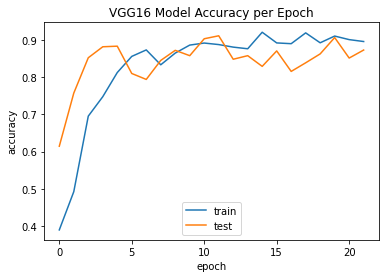

In [72]:
# PLOT ACCURACY
plt.plot(VGG16_model_history.history['accuracy'])
plt.plot(VGG16_model_history.history['val_accuracy'])
plt.title('VGG16 Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

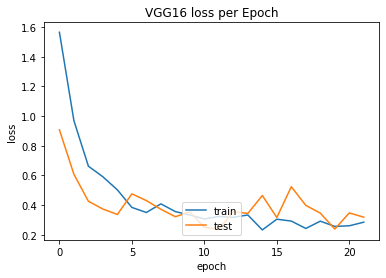

In [73]:
# PLOT LOSS
plt.plot(VGG16_model_history.history['loss'])
plt.plot(VGG16_model_history.history['val_loss'])
plt.title('VGG16 loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

In [159]:
# Begin Predictions and save to CSV

#NORMAL

image_path = 'Database/NORMAL/NORMAL (2).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[0., 1., 0.]], dtype=float32)

In [160]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/normal1.csv")

In [161]:
#NORMAL

image_path = 'Database/NORMAL/NORMAL (3).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[0., 1., 0.]], dtype=float32)

In [162]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/normal2.csv")

In [163]:
#NORMAL

image_path = 'Database/NORMAL/NORMAL (4).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[0., 1., 0.]], dtype=float32)

In [164]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/normal3.csv")

In [165]:
# Begin Predictions and save to CSV

#COVID

image_path = 'Database/COVID19/COVID-19 (12).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [166]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/covid1.csv")

In [167]:
#COVID

image_path = 'Database/COVID19/COVID-19 (266).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=1)

array([[1., 0., 0.]], dtype=float32)

In [168]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/covid2.csv")

In [169]:
#COVID

image_path = 'Database/COVID19/COVID-19 (2).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[0., 0., 1.]], dtype=float32)

In [170]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/covid3.csv")

In [171]:
#COVID

image_path = 'Database/COVID19/COVID-19 (1).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [172]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/covid4.csv")

In [173]:

#VIRAL_Pneumonia

image_path = 'Database/Viral_Pneumonia/Viral Pneumonia (540).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=0)

array([[0., 1., 0.]], dtype=float32)

In [174]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/vp1.csv")

In [175]:
#Viral_Pneumonia

image_path = 'Database/Viral_Pneumonia/Viral Pneumonia (541).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[0., 0., 1.]], dtype=float32)

In [176]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/vp2.csv")

In [177]:
#Viral_Pneumonia

image_path = 'Database/Viral_Pneumonia/Viral Pneumonia (542).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = VGG16_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[0., 1., 0.]], dtype=float32)

In [178]:
pd.DataFrame(predictions).to_csv("VGG16_model/Predictions/vp3.csv")

In [124]:
df=pd.DataFrame(columns=['col1', 'col2', 'col3'])


# Verify columns to assigned names

for i in range(1,501):
  image_path = f'Database/Viral_Pneumonia/Viral Pneumonia ({i+500}).png' 
  # image_path = f'Database/COVID19/COVID-19 ({i+400}).png'
  # image_path = f'Database/NORMAL/NORMAL ({i}).png' 
  image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224, 224))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  predictions = VGG16_model.predict(input_arr)
  preds=np.around(predictions, decimals=3)[0]
  df.loc[i-1] = preds
  print(i)

m = np.zeros_like(df.values)
m[np.arange(len(df)), df.values.argmax(1)] = 1

df1 = pd.DataFrame(m, columns = df.columns).astype(int)
df1.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,col1,col2,col3
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0


In [129]:
df1[df1["col3"]==1].value_counts()

col1  col2  col3
0     0     1       256
dtype: int64

In [127]:
df1.head(50)

,col1,col2,col3
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,0,0,1
9,0,0,1


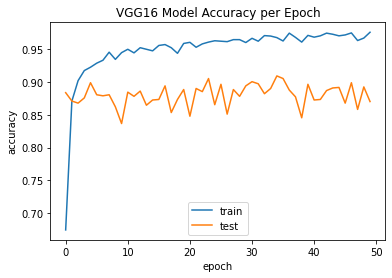

In [ ]:
# PLOT ACCURACY
plt.plot(VGG16_model_history.history['accuracy'])
plt.plot(VGG16_model_history.history['val_accuracy'])
plt.title('VGG16 Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

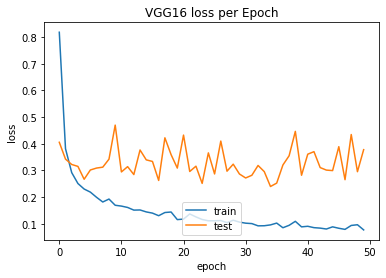

In [ ]:
# PLOT LOSS
plt.plot(VGG16_model_history.history['loss'])
plt.plot(VGG16_model_history.history['val_loss'])
plt.title('VGG16 loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()